In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
risk_df = pd.read_csv('../pcms_hackathon_data/train/risk.csv')
diagnosis_df=pd.read_csv('../pcms_hackathon_data/train/diagnosis.csv')

Counts:
has_diagnosis
0    5383
1    2617
Name: count, dtype: int64

Average Risk Score:
has_diagnosis
0    1.116743
1    2.847318
Name: risk_score, dtype: float64


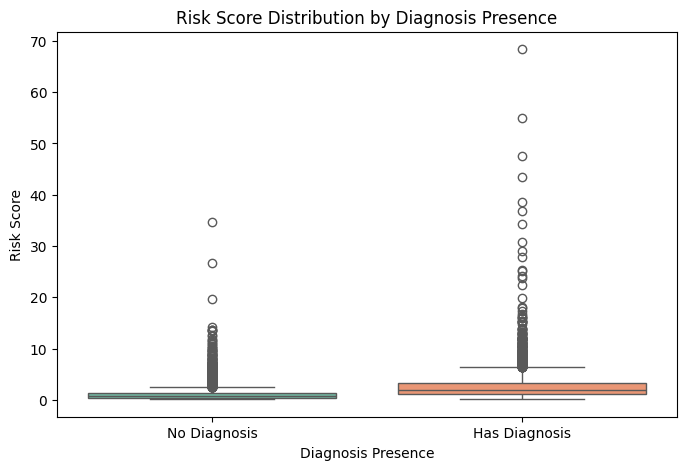

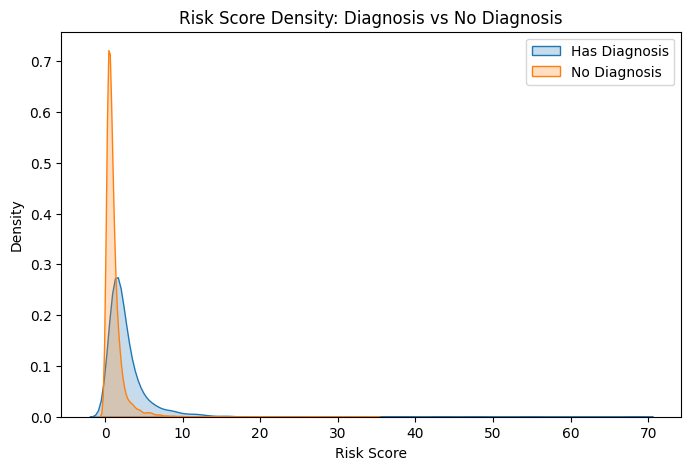

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

diagnosis_flag = diagnosis_df[['patient_id']].drop_duplicates()
diagnosis_flag['has_diagnosis'] = 1

risk_with_diag = risk_df.merge(diagnosis_flag, on='patient_id', how='left')

risk_with_diag['has_diagnosis'] = risk_with_diag['has_diagnosis'].fillna(0).astype(int)

print("Counts:")
print(risk_with_diag['has_diagnosis'].value_counts())

avg_risk = risk_with_diag.groupby('has_diagnosis')['risk_score'].mean()
print("\nAverage Risk Score:")
print(avg_risk)

plt.figure(figsize=(8,5))
sns.boxplot(
    data=risk_with_diag,
    x='has_diagnosis',
    y='risk_score',
    palette='Set2'
)
plt.xticks([0, 1], ['No Diagnosis', 'Has Diagnosis'])
plt.title("Risk Score Distribution by Diagnosis Presence")
plt.xlabel("Diagnosis Presence")
plt.ylabel("Risk Score")
plt.show()

plt.figure(figsize=(8,5))
sns.kdeplot(
    data=risk_with_diag[risk_with_diag['has_diagnosis']==1]['risk_score'],
    label='Has Diagnosis',
    shade=True
)
sns.kdeplot(
    data=risk_with_diag[risk_with_diag['has_diagnosis']==0]['risk_score'],
    label='No Diagnosis',
    shade=True
)
plt.title("Risk Score Density: Diagnosis vs No Diagnosis")
plt.xlabel("Risk Score")
plt.legend()
plt.show()


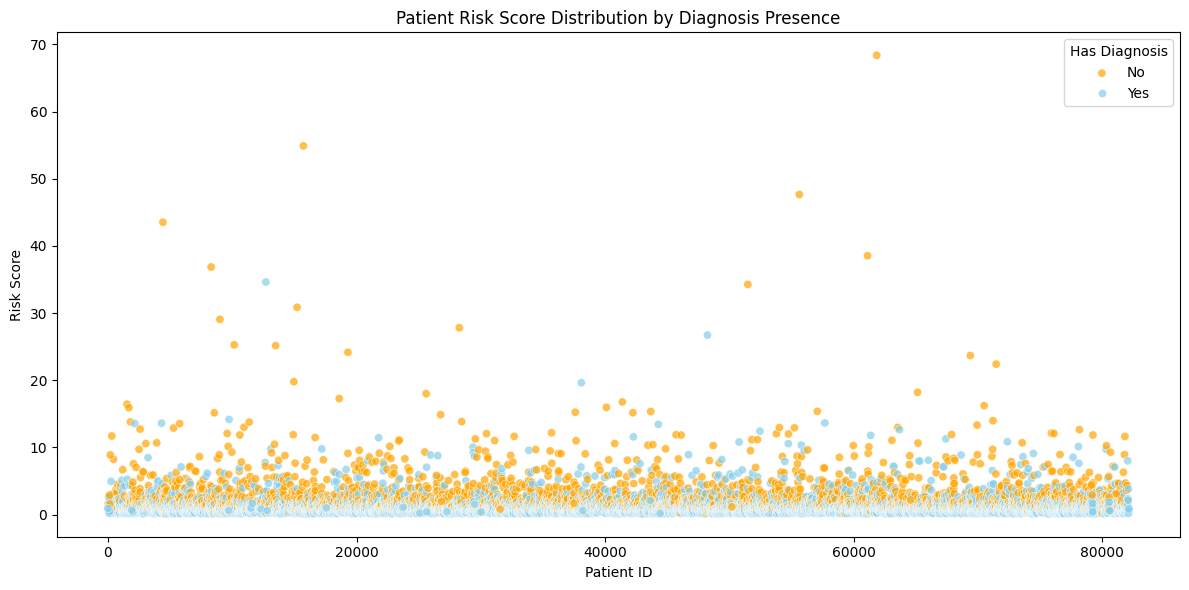

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


diagnosis_flag = diagnosis_df[['patient_id']].drop_duplicates()
diagnosis_flag['has_diagnosis'] = 1

risk_with_diag = risk_df.merge(diagnosis_flag, on='patient_id', how='left')
risk_with_diag['has_diagnosis'] = risk_with_diag['has_diagnosis'].fillna(0).astype(int)

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=risk_with_diag,
    x='patient_id',
    y='risk_score',
    hue='has_diagnosis',
    palette={0: 'skyblue', 1: 'orange'},
    alpha=0.7
)
plt.title("Patient Risk Score Distribution by Diagnosis Presence")
plt.xlabel("Patient ID")
plt.ylabel("Risk Score")
plt.legend(title="Has Diagnosis", labels=["No", "Yes"])
plt.tight_layout()
plt.show()


Diagnosis features created successfully!
Shape: (2617, 18)

 Correlation with risk_score:
risk_score                 1.000000
num_chronic_conditions     0.377092
num_conditions             0.377092
chronic_condition_ratio    0.322784
diabetes_count             0.284086
hypertension_count         0.280926
has_cancer_history         0.208401
cancer_count               0.208401
patient_id                -0.016482
Name: risk_score, dtype: float64


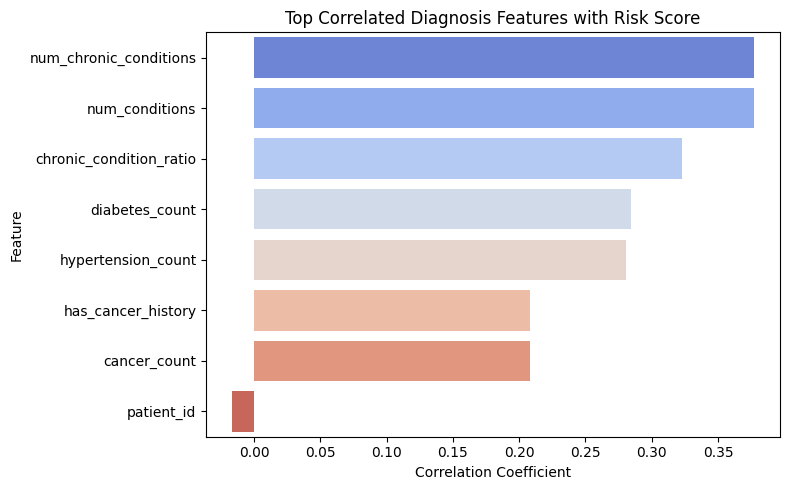

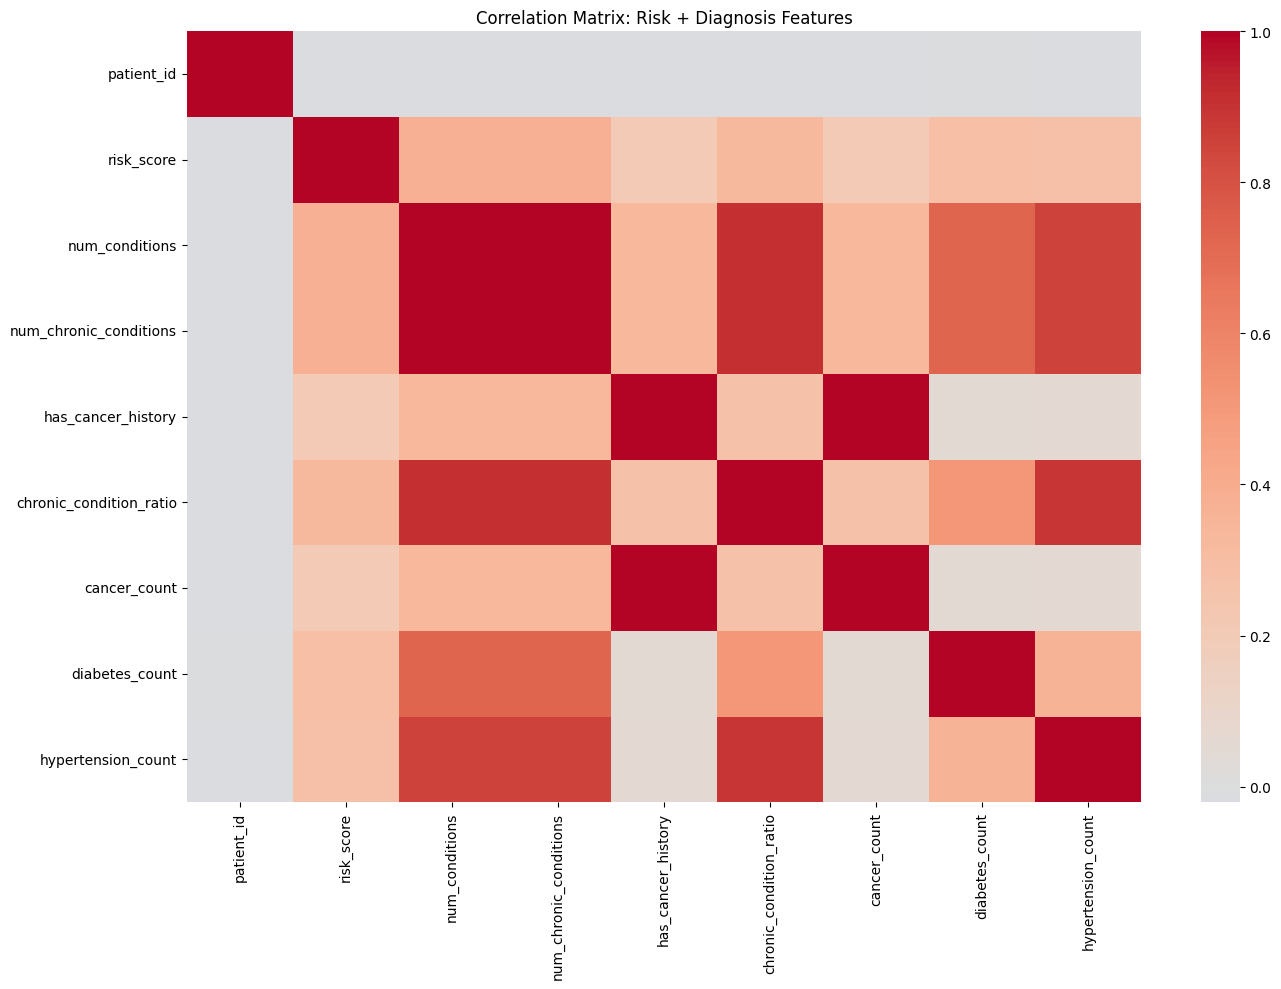


 diagnosis_final.csv and merged_diag_risk.csv saved successfully!


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cond_name_dummies = pd.get_dummies(diagnosis_df['condition_name'], prefix='cond')
cond_desc_dummies = pd.get_dummies(diagnosis_df['condition_description'], prefix='desc')

diagnosis_binary = pd.concat(
    [diagnosis_df[['patient_id']], cond_name_dummies, cond_desc_dummies],
    axis=1
)

diagnosis_binary = diagnosis_binary.groupby('patient_id').max().reset_index()

diagnosis_agg = (
    diagnosis_df.groupby('patient_id')
    .agg({
        'condition_name': 'nunique',
        'is_chronic': lambda x: (x == 't').sum()
    })
    .reset_index()
    .rename(columns={
        'condition_name': 'num_conditions',
        'is_chronic': 'num_chronic_conditions'
    })
)

diagnosis_final = diagnosis_agg.merge(diagnosis_binary, on='patient_id', how='left')
diagnosis_final.fillna(0, inplace=True)

diagnosis_final['has_cancer_history'] = (
    diagnosis_final.filter(like='CANCER').sum(axis=1) > 0
).astype(int)

diagnosis_final['chronic_condition_ratio'] = np.where(
    diagnosis_final['num_conditions'] > 0,
    diagnosis_final['num_chronic_conditions'] / diagnosis_final['num_conditions'],
    0
)

condition_counts = (
    diagnosis_df
    .groupby(['patient_id', 'condition_name'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

rename_map = {
    'CANCER': 'cancer_count',
    'DIABETES': 'diabetes_count',
    'HYPERTENSION': 'hypertension_count'
}
condition_counts.rename(columns=rename_map, inplace=True)

diagnosis_final = diagnosis_final.merge(condition_counts, on='patient_id', how='left')
for col in ['cancer_count', 'diabetes_count', 'hypertension_count']:
    if col in diagnosis_final.columns:
        diagnosis_final[col] = diagnosis_final[col].fillna(0).astype(int)
    else:
        diagnosis_final[col] = 0

print("Diagnosis features created successfully!")
print("Shape:", diagnosis_final.shape)



merged_diag_risk = risk_df.merge(diagnosis_final, on='patient_id', how='left')
merged_diag_risk.fillna(0, inplace=True)

corr_matrix = merged_diag_risk.corr(numeric_only=True)

risk_corr = corr_matrix['risk_score'].sort_values(ascending=False)
print("\n Correlation with risk_score:")
print(risk_corr.head(20))


top_corr = risk_corr[1:19]  
plt.figure(figsize=(8, 5))
sns.barplot(x=top_corr.values, y=top_corr.index, palette='coolwarm')
plt.title("Top Correlated Diagnosis Features with Risk Score")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Correlation Matrix: Risk + Diagnosis Features")
plt.tight_layout()
plt.show()


diagnosis_final.to_csv("diagnosis_final.csv", index=False)
merged_diag_risk.to_csv("merged_diag_risk.csv", index=False)

print("\n diagnosis_final.csv and merged_diag_risk.csv saved successfully!")
